### Introduction

A list of the resources I used:
- Good reference to understand the terms used in RL: https://towardsdatascience.com/the-complete-reinforcement-learning-dictionary-e16230b7d24e
- Article useful for building a custom environment based off an example that isn't a game: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e 
- OpenAI Gym Documentation: https://www.gymlibrary.ml 
- Stable Baselines 3 Documentation (Page is the chosen model): https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#stable_baselines3.dqn.CnnPolicy 
- A good two part tutorial: https://towardsdatascience.com/ultimate-guide-for-reinforced-learning-part-1-creating-a-game-956f1f2b0a91  
- All about DQN: https://avandekleut.github.io/dqn/ 



### Imports

In [1]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString, Point
import random
import time
from rasterio.features import rasterize
from IPython import display
import geopandas as gpd
import pandas as pd
from skimage.feature import match_template
%matplotlib inline
%config InlineBackend.figure_format='retina'
from temp_env import TemplateMatchingEnv as tmenv
import utils
font = cv2.FONT_ITALIC
os.chdir('/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method')


path_sample_image = './data/tif_files/LKg_1092_1990.tif'
path_sample_template_1 = './data/templates/temp_1.tif'
path_sample_template_2 = './data/templates/temp_2.tif'

path_testing_image = './data/testing/testing_board.tif'
path_testing_image_red = './data/testing/testing_board_red.tif'
path_testing_image_red_grid = './data/testing/testing_board_red_grid.tif'

path_testing_template_1 = './data/testing/testing_template.tif'


path_1092_1990 = './data/tif_files/LKg_1092_1990.tif'
path_1092_1988 = './data/tif_files/LKg_1092_1990.tif'
path_1092_1989 = './data/tif_files/LKg_1092_1990.tif'

### General Functions


In [5]:
def crop_image(image,y_start,x_start,height,width):
    return image[y_start:y_start+height,x_start:x_start+width]

def rect_out_rast(y,x,height,width):
    p = Polygon([[x, y], [x+width, y+0], [x+width, y+height], [x+0, y+height]])
    return rasterize([p],out_shape=(width,height)).T

def Sum_of_squared_differences(roi,temp):
    ssd = np.sum((np.array(roi, dtype=np.float32) - np.array(temp, dtype=np.float32))**2)
    return ssd

def Normalized_cross_correlation(roi,temp):
    cc = np.sum(roi*temp)
    nor = np.sqrt(np.sum(roi**2)) * np.sqrt(np.sum(temp**2))
    return cc/nor

def ssd(A,B):
  dif = A.ravel() - B.ravel()
  return np.dot( dif, dif )

def action_rules(action):
    if action==None:
        return action
    elif action<4:
        return action+4
    else:
        return action-4

def tuple_addition(a,b):
    return tuple(map(sum, zip(a, b)))

def get_action_meanings():
        return {0: "South", 1: "Southwest", 2: "West", 3: "Northwest",
                4: "North", 5: "Northeast", 6: "East", 7: "Southeast",
                -1: "No Moves"}
        
def calc_termination_point(point,multipliers,dimensions):
            termination_y = point[0] + multipliers[0] * dimensions[0]
            termination_x = point[1] + multipliers[1] * dimensions[1]
            return (termination_y,termination_x)
        

def calc_increment_space(image_size,template_size):
    actual_increments = image_size/template_size
    possible_increments = int(np.floor(actual_increments))
    return np.arange(0,template_size*(possible_increments+1),template_size)

def remove_black(image):
    blue_band = image[:,:,0]
    green_band = image[:,:,1]
    red_band = image[:,:,2]
    blue_mask = blue_band<=80
    green_mask = green_band<=80
    red_mask = red_band<=80
    mask = blue_mask&green_mask&red_mask
    blue_band[mask] = 255
    green_band[mask] = 255
    red_band[mask] = 255
    newimagebgr = np.stack((blue_band,green_band, red_band),axis = 2)
    newimage = np.stack((red_band,green_band, blue_band),axis = 2)
    plt.imshow(newimage)
    cv2.imwrite('newimage.png',newimage)
    return newimagebgr

def remove_white(image):
    blue_band = image[:,:,0]
    green_band = image[:,:,1]
    red_band = image[:,:,2]
    blue_mask = blue_band>=80
    green_mask = green_band>=80
    red_mask = red_band>=80
    mask = blue_mask&green_mask&red_mask
    blue_band[mask] = 255
    green_band[mask] = 255
    red_band[mask] = 255
    newimagebgr = np.stack((blue_band,green_band, red_band),axis = 2)
    newimage = np.stack((red_band,green_band, blue_band),axis = 2)
    plt.imshow(newimage)
    cv2.imwrite('newimage.png',newimage)
    return newimagebgr

def plot_line_string(point_list,reduce_factor=1):
    # have to reverse the order of the points for geopandas as well
    reduced_list = [(int(x[1]*reduce_factor),int(x[0]*reduce_factor)) for x in point_list]
    gpd.GeoSeries(LineString(reduced_list)).plot(ax=ax)
    gpd.GeoSeries(Point(reduced_list[0])).plot(ax=ax)
    
def read_image_to_color(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def remove_white_hsv_meth(img):
    # Convert to HSV colourspace and extract just the Saturation
    Sat = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[..., 1]
    # Find best (Otsu) threshold to divide black from white, and apply it
    _ , mask = cv2.threshold(Sat,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # At each pixel, choose foreground where mask is set and background elsewhere
    return np.where(mask[...,np.newaxis], img, 80)

def resize_image(image, reduce_factor=0.1):
    new_res = (int(image.shape[1]*reduce_factor), int(image.shape[0]*reduce_factor))
    return cv2.resize(image, new_res)
   

### Testing SSD Scores

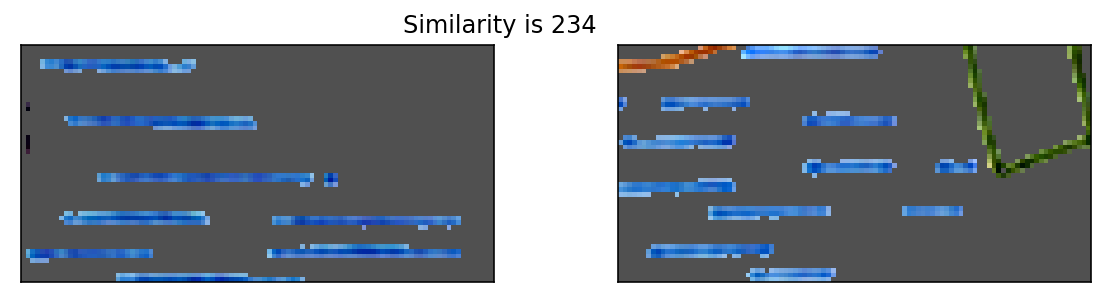

In [2]:
img = cv2.imread(path_sample_image)

template = utils.crop_image(utils.read_image_to_color(img),1905,1640,50,100)
window = utils.crop_image(utils.read_image_to_color(img),7575,10138,50,100)
fig,ax = plt.subplots(1,2,figsize=(8,12),sharey=True,sharex=True)
b = utils.remove_white_hsv_meth(window)
ax[0].imshow(utils.remove_white_hsv_meth(template))
ax[1].imshow(utils.remove_white_hsv_meth(window))
ax[1].set_title(f"Similarity is {utils.ssd(utils.remove_white_hsv_meth(template),utils.remove_white_hsv_meth(window))}",x=-0.25)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
fig.patch.set_facecolor('white')

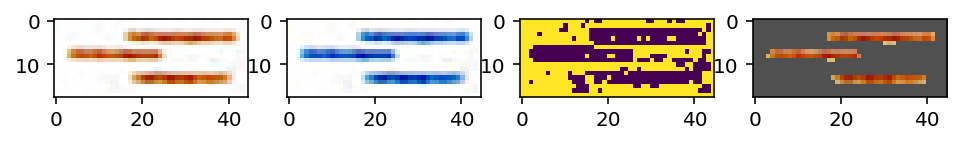

In [11]:
fig, ax = plt.subplots(1,4,figsize=(8,16))
img_raw = cv2.imread(path_sample_template_1)
img = utils.read_image_to_color(img_raw)

img_no_white = 80 * 3 < img_raw[: ,: ,0] + img_raw[: ,: ,1] + img_raw[: ,: ,2]

ax[0].imshow(img_raw)
ax[1].imshow(img)
ax[2].imshow(img_no_white)
ax[3].imshow(utils.read_image_to_color(utils.remove_white_hsv_meth(img)))

113.33333333333333


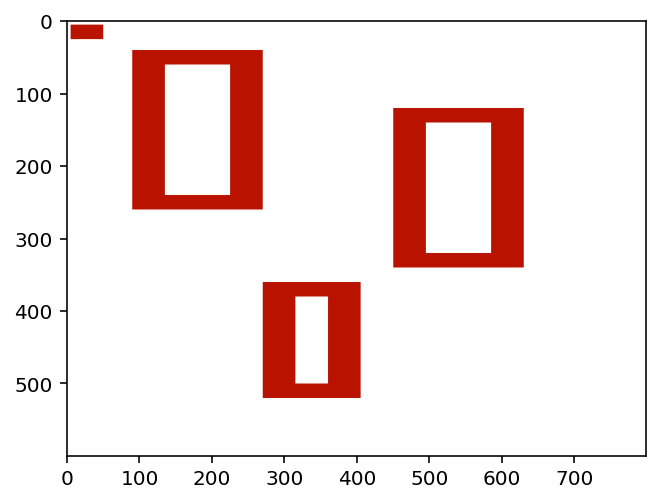

In [3]:
path = './data/testing/testing_board_red.tif'
red = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),path)), cv2.COLOR_BGR2RGB)
t_y = 5
t_h = 20
t_x = 5
t_w = 45
template = red[t_y:t_y+t_h,t_x:t_x+t_w]
sample = utils.crop_image(red,100,10,20,45)

res_list = []
for i in [0,1,2]:
    res_list.append(utils.ssd(sample[:,:,i],
                        template[:,:,i]))
res_mean = sum(res_list) / len(res_list)
print(res_mean)
plt.imshow(red)



### General Classes

In [3]:
class Point2(object):
    def __init__(self, name, y_max, x_max, y_min, x_min):
        self.y = 0
        self.x = 0
        self.y_max = y_max
        self.x_max = x_max
        self.y_min = y_min
        self.x_min = x_min
        self.name = name
    
    def set_position(self, y, x):
        self.y = self.clamp(y, self.y_min, self.y_max)
        self.x = self.clamp(x, self.x_min, self.x_max)
    
    def get_position(self):
        return (self.y, self.x)
    
    def move(self, del_y, del_x):
        self.y += del_y
        self.x += del_x
        
        self.y = self.clamp(self.y, self.y_min, self.y_max)
        self.x = self.clamp(self.x, self.x_min, self.x_max)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)
    
class Frame(Point2):
    def __init__(self,name,y_max, x_max, y_min, x_min, T_HEIGHT, T_WIDTH):
        super(Frame, self).__init__(name, y_max, x_max, y_min, x_min)
        self.icon = cv2.cvtColor(rect_out_rast(y_min,x_min,T_HEIGHT,T_WIDTH), cv2.COLOR_GRAY2RGB)
        self.T_WIDTH = T_WIDTH
        self.T_HEIGHT = T_HEIGHT
        # self.icon = cv2.imread(os.path.join(os.getcwd(),"notebooks","chopper.png")) / 255
        self.icon = cv2.resize(self.icon, (self.T_WIDTH, self.T_HEIGHT)) #cv2 resize method is width then height



### Sandbox

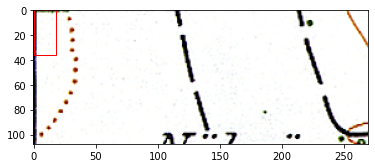

In [32]:
p = patches.Rectangle((0,
                        0), #origin
                        18, #x-dimension
                        36, #y-dimension
                        linewidth=1, 
                        edgecolor='r', 
                        facecolor='None',
                        rasterized=True)


fig, ax = plt.subplots()
x = 0
y = 0
ax.imshow(image_norm[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

# Create a Rectangle patch
ax.add_patch(p)

### Load Data

In [7]:

image = cv2.imread(path_sample_image)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_grey = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
image_norm = (image_color/255).astype(float)

template =cv2.imread(path_sample_template_1)
template_color = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template_grey = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)
template_norm = (template_color/255).astype(float)

test_image = cv2.imread(path_testing_image)
test_image_color = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_grey = cv2.cvtColor(test_image_color, cv2.COLOR_BGR2GRAY)
test_image_norm = (test_image_color/255).astype(float)

test_template =cv2.imread(path_testing_template_1)
test_template_color = cv2.cvtColor(test_template, cv2.COLOR_BGR2RGB)
test_template_grey = cv2.cvtColor(test_template_color, cv2.COLOR_BGR2GRAY)
test_template_norm = (test_template_color/255).astype(float)

I_HEIGHT, I_WIDTH, I_DEPTH = image.shape
T_HEIGHT, T_WIDTH, T_DEPTH = template.shape

print('Data Type: %s' % image_norm.dtype)
print('Min: %.3f, Max: %.3f' % (image_norm.min(), image_norm.max()))


Data Type: float64
Min: 0.000, Max: 1.000


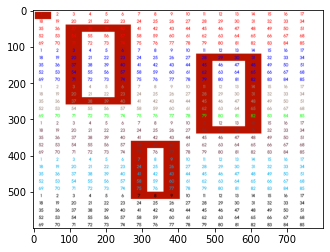

In [10]:
plt.imshow(read_image_to_color(cv2.imread(path_testing_image_red_grid)))

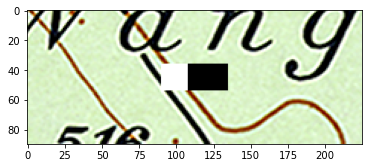

In [137]:
cropped = crop_image(image_norm,1000,2000,template_norm.shape[0]*5,template_norm.shape[1]*5)
# roi_R = cropped[:,:,0]
# roi_G = cropped[:,:,1]
# roi_B = cropped[:,:,2]

# res_list = []

# for i in [0,1,2]:
#     res_list.append(Sum_of_squared_differences(cropped[:,:,i],template_norm[:,:,i]))
    
# res_mean = sum(res_list) / len(res_list)
window_y = int(np.floor(5/2)) * 18
window_x = int(np.floor(5/2)) * 45
# # an optional window to draw on the frame during debugging centered in the frame
test_polygon = cv2.cvtColor(rect_out_rast(0,
                             0,
                             45,
                             18),cv2.COLOR_GRAY2BGR)

cropped[window_y:window_y + 18,window_x:window_x + 45] = test_polygon
plt.imshow(cropped)

Original was (114, 188, 3)
New is (119, 158, 3)
Image is (2500, 3334, 3)


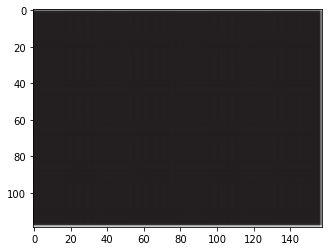

In [45]:
def resize_template()
n_height_intervals = int(np.floor(test_image_norm.shape[0] / test_template_norm.shape[0]))
height = int(np.floor(test_image_norm.shape[0] / n_height_intervals))

n_width_intervals = int(np.floor(test_image_norm.shape[1] / test_template_norm.shape[1]))
width = int(np.floor(test_image_norm.shape[1] / n_height_intervals))

dim = (width,height)

# resize image
resized = cv2.resize(test_template_norm, dim, interpolation = cv2.INTER_AREA)
print(f"Original was {test_template_norm.shape}")
print(f"New is {resized.shape}")
print(f"Image is {test_image_norm.shape}")

plt.imshow(resized)

In [5]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(test_image_norm)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w

NameError: name 'plt' is not defined

### Inspect Map

In [36]:
x,y = 0,0
print(y,y+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)

0 18
0 45
----------
18 36
-45 0
----------
0 18
-45 0
----------
-18 0
-45 0
----------
-18 0
0 45
----------
-18 0
45 90
----------
0 18
45 90
----------
18 36
45 90
----------
18 36
0 45


In [37]:
x,y = int(0),int(0)

def calc_surround_origins(x,y,T_WIDTH,T_HEIGHT):
    origins = [(x,y),
            (x-T_WIDTH,y+T_HEIGHT),
            (x-T_WIDTH,y),
            (x-T_WIDTH,y-T_HEIGHT),
            (x,y-T_HEIGHT),
            (x+T_WIDTH,y-T_HEIGHT),
            (x+T_WIDTH,y),
            (x+T_WIDTH,y+T_HEIGHT),
            (x,y+T_HEIGHT)]
    return origins

def calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT):
    all_surround = [image[y:y+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH]]
    return all_surround[1:]
    

def find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT):
    mask = []
    for n,t in enumerate(calc_surround_origins(x,y,T_WIDTH,T_HEIGHT)):
        if t[0] < 0 or t[1] < 0:
            pass
        else:
            mask.append(n)
    all_surround = calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT)
    
    return [all_surround[i] for i in mask]


find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT)

IndexError: list index out of range

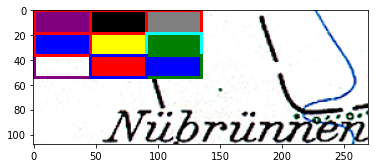

In [ ]:
colos = []
fig, ax = plt.subplots()

ax.imshow(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

x,y = 45,18
# Create a Rectangle patch
ax.add_patch(patches.Rectangle((x,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='y', 
                         facecolor='yellow'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='purple', 
                         facecolor='none'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='purple'))

ax.add_patch(patches.Rectangle((x,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='black'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='grey'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='cyan', 
                         facecolor='green'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='g', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='b', 
                         facecolor='red'))

In [ ]:
template = cv2.imread(path_temp,0)

height, width = template.shape
loc, res = template_matching(image,template,default_threshold, method)

for (x,y) in zip(loc[0], loc[1]):
    cv2.rectangle(image_color, (x,y), (x+width, y+height), (0,0,255), 2)

### Building Environment

Built off the boilerplate in: 

https://blog.paperspace.com/creating-custom-environments-openai-gym/


In [5]:
class TemplateMatchingEnv(gym.Env):
    def __init__(self, image_path, temp_loc, obs_shape_mult=(3,3),compare_method='SSD',sim_threshold=1000,print_st=False):
        super(TemplateMatchingEnv, self).__init__()

        self.print_st = print_st
        self.compare_method = compare_method
        self.sim_threshold = sim_threshold
        
        # load image
        self.image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        # self.image = self.image_color # (self.image_color/255).astype(float).copy()
        self.image_array = self.image.copy()
        self.image_shape = self.image_array.shape
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_shape

        # load template 
        # self.template = cv2.cvtColor(cv2.imread(template_path), cv2.COLOR_BGR2RGB)
        self.template = self.image_array[temp_loc[0]:temp_loc[0]+temp_loc[2],temp_loc[1]:temp_loc[1]+temp_loc[3]]
        self.template_array = self.template.copy()
        # self.template_array = np.ones(self.template_array.shape)
        self.T_HEIGHT, self.T_WIDTH, self.T_DEPTH = self.template_array.shape
        
        self.obs_shape_mult_height = obs_shape_mult[0]
        self.obs_shape_mult_width = obs_shape_mult[1]
        self.obs_space_height = self.T_HEIGHT * self.obs_shape_mult_height
        self.obs_space_width = self.T_WIDTH * self.obs_shape_mult_width
        
        # Define a 2-D observation space
        self.observation_shape = (self.obs_space_height,
                                  self.obs_space_width,
                                  3)
        self.observation_space = spaces.Box(low = 0,#np.zeros(self.observation_shape), 
                                            high = 255,#np.ones(self.observation_shape),
                                            shape = self.observation_shape,
                                            dtype = np.uint8)
        
        # Action to choose the next agent location 
        # 0 -> 8 corresponds to the list of neighbor frames 
        self.action_space = spaces.Discrete(8)
        
        # # Create a canvas to render the environment images upon 
        # self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum moves the frame can make before resetting the episode
        self.max_moves = 8
        
        # store window origin, dependent on observation multipliers and tempalte size
        self.window_y =  int(np.floor(self.obs_shape_mult_height/2)) * self.T_HEIGHT
        self.window_x = int(np.floor(self.obs_shape_mult_width/2)) * self.T_WIDTH
        
    def reset(self):
        if self.print_st==True:
            print("Setting new episode.")
        self.canvas = np.ones(self.observation_shape)
        self.actions = np.arange(0,self.action_space.n)
        
        # reset the image
        self.image_array = self.image.copy()
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_shape
        
        # set action and movement tracking variables back to nulls
        self.previous_action = None
        self.moves_taken = 0
        self.moves_left = self.max_moves
        self.log_points = []
        self.log_moves = []
        self.log_res = []
        self.log_closed = False
        self.log_actions = np.arange(0,self.action_space.n)
        self.ep_return  = 0
        
        # intialise the frame
        # set some buffers to make sure the frame doesn't eventually extend past image
        self.height_buffer = self.T_HEIGHT*(self.obs_shape_mult_height+1)
        self.width_buffer = self.T_WIDTH*(self.obs_shape_mult_width+1)
        self.y_max = self.I_HEIGHT-(self.height_buffer)
        self.x_max = self.I_WIDTH-(self.width_buffer)
        
        # create y and x lists for possible point locations of points (this is a grid)
        # self.lin_y = np.linspace(0,self.y_max,int(np.floor(
        #     self.y_max/self.T_HEIGHT)),dtype="int")
        self.lin_y = calc_increment_space(self.I_HEIGHT,self.T_HEIGHT)
        self.lin_x = calc_increment_space(self.I_WIDTH,self.T_WIDTH)
        # self.lin_x = np.linspace(0,self.x_max,int(np.floor(
        #     self.x_max/self.T_WIDTH)),dtype="int")
        
        # create an origin for the frame for the episode
        self.random_y_origin = random.choice(self.lin_y[self.lin_y<self.y_max]) # random.randint(0, self.y_max)
        self.random_x_origin = random.choice(self.lin_x[self.lin_x<self.x_max]) # random.randint(0, self.x_max)
        self.episode_origin = (self.random_y_origin,self.random_x_origin)
        self.previous_point = self.episode_origin
        
        # append origin point to the points log
        self.log_points.append(self.episode_origin)
        self.log_moves.append("Origin")
        
        # subset the image array to create the observation frame
        self.frame_array = crop_image(self.image_array,
                                      self.random_y_origin,
                                      self.random_x_origin,
                                      self.obs_space_height,
                                      self.obs_space_width)

        # Intialise the elements (for now this only includes the array)
        self.elements = [self.frame_array]#,self.window]
        
        # Draw elements on the canvas
        self.draw_elements_on_canvas()
        
        # return the observation
        return self.canvas 
        
    def draw_elements_on_canvas(self):
        self.canvas = self.frame_array
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            plt.imshow(self.canvas)
        
        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()
    
    
    def gen_possible_actions(self):
        # log the previous point
        if self.moves_taken < 1:
            self.previous_point = self.episode_origin
        else:
            self.previous_point = self.updated_point
        
        # get possible actions and point
        self.possible_actions = self.actions
        self.possible_points = self.generate_possible_pts()
                
        # self.termination_points = calc_termination_point(self.previous_point,
        #                                                  (env.obs_shape_mult_height,env.obs_shape_mult_width),
        #                                                  (env.T_HEIGHT,env.T_WIDTH))
        
        remove_actions = []
        # evaluate possible points 
        for n,pt in enumerate(self.possible_points):
            t_pt = calc_termination_point(pt,
                                          (self.obs_shape_mult_height,self.obs_shape_mult_width),
                                          (self.T_HEIGHT,self.T_WIDTH))
            if pt==self.episode_origin:
                if self.moves_taken < 2:
                    if self.print_st==True:
                        print('Early close attempt possible. Remove.')
                    remove_actions.append(n)
                else:
                    pass
            elif pt in self.log_points:
                if self.print_st==True:
                    print('Point already used')
                remove_actions.append(n)
            elif pt[0] < 0 or pt[0]  > self.y_max:
                if self.print_st==True:
                    print('Point is not on image')
                remove_actions.append(n)
            elif pt[1] < 0 or pt[1] > self.x_max:
                if self.print_st==True:
                    print('Point is not on image')
                remove_actions.append(n)
            elif pt[0] < 0+(2*self.T_HEIGHT) or pt[0]  > self.y_max-(2*self.T_HEIGHT):
                if self.print_st==True:
                    print("Point is within buffer edge of border")
                remove_actions.append(n)
            elif pt[1] < 0+(2*self.T_WIDTH) or pt[1]  > self.x_max-(2*self.T_WIDTH):
                if self.print_st==True:
                    print("Point is within buffer edge of border")
                remove_actions.append(n)
            elif t_pt[0] < 0 or t_pt[0]  > self.y_max:
                if self.print_st==True:
                    print("Termination point is outside of the border")
                remove_actions.append(n)
            elif t_pt[1] < 0 or t_pt[1]  > self.x_max:
                if self.print_st==True:
                    print("Termination point is outside of the border")
                remove_actions.append(n)
            else:
                if self.print_st==True:
                    print("Point never used")
                else:
                    pass
        
        self.possible_actions = np.delete(self.possible_actions,remove_actions)
        
        
    
    # def choose_action(self):
    #     self.gen_possible_actions()
    #     if len(self.possible_actions)>0:
    #         return random.choice(self.possible_actions)
    #     else:
    #         if self.print_st==True:
    #             print('No actions possible, next epsiode')
    #         return -1
            
    def step(self,action):
        info = {}
        # make sure episode is continuing
        done = False
        self.action = action
        self.gen_possible_actions()
        if self.action not in self.possible_actions:
            reward = self.ep_return
            if self.print_st==True:
                print("Action Not Possible")
            done = True
        else:
            # apply the action to the frame
            if self.print_st==True:
                print(f"Action is {self.action}, {get_action_meanings()[self.action]}")
            if self.action == 0: # south
                self.movement = (self.T_HEIGHT,0)
            elif self.action == 1: # southwest
                self.movement = (self.T_HEIGHT,self.T_WIDTH*-1)
            elif self.action == 2: # west
                self.movement = (0,self.T_WIDTH*-1)
            elif self.action == 3: # northwest
                self.movement = (self.T_HEIGHT*-1,self.T_WIDTH*-1)
            elif self.action == 4: # north
                self.movement = (self.T_HEIGHT*-1,0)
            elif self.action == 5: # northeast
                self.movement = (self.T_HEIGHT*-1,self.T_WIDTH)
            elif self.action == 6: # east
                self.movement = (0,self.T_WIDTH)
            elif self.action == 7: # southeast
                self.movement = (self.T_HEIGHT,self.T_WIDTH)
            elif self.action == -1: # no moves
                done = True
                reward = self.ep_return
                return self.canvas, reward, done, info 
                
            
            # update canvas and logs
            # store some data
            self.previous_action = self.action
            self.updated_point = tuple_addition(self.previous_point,self.movement)
            self.log_points.append(self.updated_point)
            self.log_moves.append(get_action_meanings()[self.action])
            # move the frame by the action movements (this is really a recropping)
            # if self.moves_taken==0:
            #     pass
            # else:
            self.frame_array = crop_image(self.image_array,
                                        self.updated_point[0],#-self.window_y,#
                                        self.updated_point[1],#-self.window_x,#
                                        #   self.random_y_origin + self.movement[0],#self.frame_y
                                        #   self.random_x_origin + self.movement[1],#self.frame_x
                                        self.obs_space_height,
                                        self.obs_space_width)
                
            # Decrease the moves remaining 
            self.moves_left -= 1 
            self.moves_taken += 1 
            if self.print_st==True:
                print(f"Moves remaining, {self.moves_left}")
            
            # test the window and template
            if self.test_match() is True:
                if self.print_st==True:
                    print("Match")
                # Reward for a match.
                reward_a = 1
                # Reward for contiguous matches.
                reward_b = 1 * self.moves_taken
                reward = reward_a+reward_b
                
                if self.log_points[0] == self.log_points[-1]:
                    if self.print_st==True:
                        print('Episode origin point visited. Loop created. Next Episode')
                    self.log_closed = True
                    reward += self.moves_taken*2
                    
                    # Increment the episodic return
                    self.ep_return += reward

                    # Draw elements on the canvas
                    self.draw_elements_on_canvas()
                    self.moves_left = 0
                    done = True
                else:
                    # Reset the moves allowed
                    self.moves_left = self.max_moves
            else:
                if self.print_st==True:
                    print('No match, next epsiode')
                reward = 0
                done = True
            
            # Increment the episodic return
            self.ep_return += reward

            # Draw elements on the canvas
            self.draw_elements_on_canvas()

            # If out of moves, end the episode.
            if self.moves_left == 0:
                done = True
            
        return self.canvas, reward, done, info
    
    def generate_possible_pts(self):
        all_moves = [(self.T_HEIGHT,0),
                        (self.T_HEIGHT,self.T_WIDTH*-1),
                        (0,self.T_WIDTH*-1),
                        (self.T_HEIGHT*-1,self.T_WIDTH*-1),
                        (self.T_HEIGHT*-1,0),
                        (self.T_HEIGHT*-1,self.T_WIDTH),
                        (0,self.T_WIDTH),
                        (self.T_HEIGHT,self.T_WIDTH)]
        return [tuple_addition(self.previous_point,pt) for pt in all_moves]
    
        
        
    def test_match(self):
        self.window_array = crop_image(self.frame_array,
                                        self.window_y,
                                        self.window_x,
                                        self.T_HEIGHT,
                                        self.T_WIDTH)
        self.window_grey = remove_white_hsv_meth(self.window_array).copy()
        self.template_grey = remove_white_hsv_meth(self.template_array).copy()
        if self.compare_method == 'SSD':            
            res_list = []
            for i in [0,1,2]:
                res_list.append(ssd(self.window_grey[:,:,i],
                                    self.template_grey[:,:,i]))
            res_mean = sum(res_list) / len(res_list)
            # result_.append(ssd_) # log results
            if self.print_st==True:
                print(f"{self.compare_method} result is {res_mean}")
            self.log_res.append(res_mean)
            if res_mean<self.sim_threshold:
                return True
            else:
                return False
            
        elif self.compare_method == 'NCC':
            res_list = []
            for i in [0,1,2]: 
                res_list.append(Normalized_cross_correlation(self.window_grey[:,:,i],
                                                             self.template_grey[:,:,i]))
            res_mean = sum(res_list) / len(res_list)
            # result_.append(ssd_) # log results
            if self.print_st==True:
                print(f"{self.compare_method} result is {res_mean}")
            self.log_res.append(res_mean)
            if res_mean>0.8:
                return True
            else:
                return False

### Testing

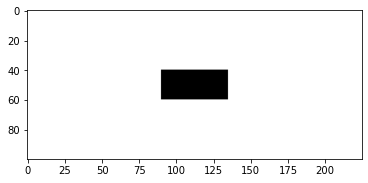

In [210]:
fig,ax = plt.subplots()
arr = env.frame_array.copy()
win = cv2.cvtColor(utils.rect_out_rast(env.window_y,env.window_x,env.T_HEIGHT,env.T_WIDTH), cv2.COLOR_GRAY2RGB)
arr[env.window_y:env.window_y+env.T_HEIGHT,env.window_x:env.window_x+env.T_WIDTH] = win
ax.imshow(arr)

In [5]:
# global variables
SIMILARTY_THRESHOLD = 150
MAX_STEPS = 100
TOTAL_EPISODES = 2000

In [6]:
env = tmenv("/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method/data/tif_files/LKg_1092_1990.tif",
                          (1900,1650,50,100), # for testing_image red(5,5,20,45),
                          obs_shape_mult=(5,5),
                          compare_method='SSD',
                          sim_threshold=SIMILARTY_THRESHOLD,
                          print_st=False)

show = False
# rewards = []
log = {"Points":{},
       "Reward":{},
       "Results":{},
       "Closed":{}}

for episode in np.arange(0,10):
    if show==True:
        print(f"EPISODE {episode}")
    if show==True:
        fig,ax = plt.subplots()
    env.reset()
    while True:
        # Take a random action
        if show==True:
            print(f"Previous action was {env.previous_action}")
            print(f"Point is {env.previous_point}")
            ax.imshow(env.frame_array)
            # ax.set_title(f"Episode {episode}")
            # gpd.GeoSeries(Point((env.window_x,env.window_y))).plot(ax=ax)
            display.display(plt.gcf())
        # action = random.choice(list(set([x for x in range(0, env.action_space.n)])
        #                             - set([action_rules(env.previous_action)])))
        action = env.action_space.sample()
        print(action)
        obs, reward, done, info = env.step(action) 
        # img = plt.imshow(env.render(mode='rgb_array'))
        # img.set_data(env.render(mode='rgb_array'))
                
        if done == True:
            log['Points'][episode] = env.log_points
            log['Reward'][episode] = env.ep_return
            log['Results'][episode] = env.log_res
            log['Closed'][episode] = env.log_closed
            # display.clear_output(wait=True)
            if show==True:
                print("Clearing")
            if show==True:
                time.sleep(0.25)
            break
    fig = None
env.close()
# print(f"Maximum reward achieved {max(rewards)}")


3
1
2
5
7
1
6
7
2
7
5
0
7
7
0
5
1
6
3
7
1
4
0
5
5
6
1
0
0
1
7
0
4


### Analysis

In [232]:
df_reward = pd.DataFrame([log['Reward']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Reward"}).set_index('Episode')
df_closed = pd.DataFrame([log['Closed']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Closed"}).set_index('Episode')
df_results = pd.DataFrame([log['Results']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Results"}).set_index('Episode')
df_points = pd.DataFrame([log['Points']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Points"}).set_index('Episode')

df = pd.concat([df_reward,df_closed,df_results,df_points],axis=1)
df

,Reward,Closed,Results,Points
Episode,,,,
0,2,False,"[107.0, 203.0]","[(3950, 8500), (3900, 8500), (3950, 8600)]"
1,0,False,[],"[(500, 0)]"
2,0,False,[161.66666666666666],"[(4850, 2000), (4900, 2000)]"
3,0,False,[219.0],"[(3650, 8900), (3600, 9000)]"
4,20,False,"[74.33333333333333, 131.0, 57.666666666666664,...","[(6700, 8400), (6650, 8400), (6600, 8400), (66..."
5,2,False,[141.0],"[(6750, 7100), (6800, 7200)]"
6,2,False,"[110.66666666666667, 201.66666666666666]","[(7850, 5300), (7900, 5200), (7950, 5200)]"
7,9,False,"[44.0, 140.0, 80.33333333333333, 156.333333333...","[(200, 8500), (200, 8600), (150, 8700), (150, ..."
8,14,False,"[70.66666666666667, 102.66666666666667, 63.666...","[(7300, 500), (7350, 500), (7300, 400), (7350,..."


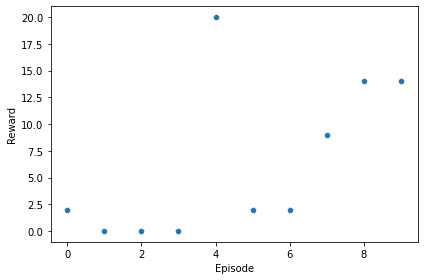

In [233]:

#[df['Reward']==df.max()['Reward']]

sns.scatterplot(data=df, x="Episode", y="Reward")
plt.tight_layout()

In [234]:
df.sort_values(by='Reward',ascending=False)

,Reward,Closed,Results,Points
Episode,,,,
4,20,False,"[74.33333333333333, 131.0, 57.666666666666664,...","[(6700, 8400), (6650, 8400), (6600, 8400), (66..."
8,14,False,"[70.66666666666667, 102.66666666666667, 63.666...","[(7300, 500), (7350, 500), (7300, 400), (7350,..."
9,14,False,"[60.0, 97.66666666666667, 98.33333333333333, 7...","[(6500, 10800), (6500, 10700), (6550, 10700), ..."
7,9,False,"[44.0, 140.0, 80.33333333333333, 156.333333333...","[(200, 8500), (200, 8600), (150, 8700), (150, ..."
0,2,False,"[107.0, 203.0]","[(3950, 8500), (3900, 8500), (3950, 8600)]"
5,2,False,[141.0],"[(6750, 7100), (6800, 7200)]"
6,2,False,"[110.66666666666667, 201.66666666666666]","[(7850, 5300), (7900, 5200), (7950, 5200)]"
1,0,False,[],"[(500, 0)]"
2,0,False,[161.66666666666666],"[(4850, 2000), (4900, 2000)]"


In [259]:
test_arr = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),path_1092_1990)), cv2.COLOR_BGR2RGB)
factor = 0.1
test_arr_sm = resize_image(test_arr,reduce_factor=factor)

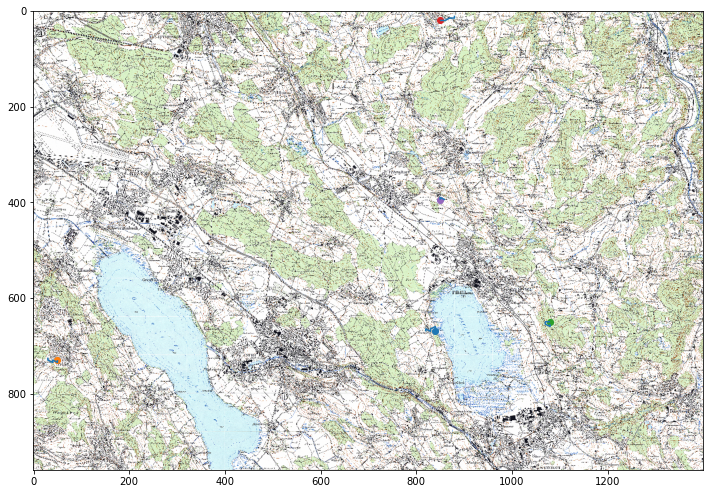

In [271]:
# look at path
fig,ax = plt.subplots(figsize=(12,12))

ax.imshow(test_arr_sm)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w


# line_string = ["LINESTRING (-1.15.12 9.9, -1.15.13 9.93)", "LINESTRING (-2.15.12 8.9, -2.15.13 8.93)"]
# invalid geometry - modified

high_reward_list = df.sort_values(by='Reward',ascending=False).iloc[0:5].index.tolist()
for epi in high_reward_list:
    plot_line_string(log['Points'][epi],reduce_factor=factor)

### Training

In [5]:
# global variables
SIMILARTY_THRESHOLD = 150

In [6]:
env = TemplateMatchingEnv("/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method/data/tif_files/LKg_1092_1990.tif",
                          (1900,1650,50,100), # for testing_image red(5,5,20,45),
                          obs_shape_mult=(5,5),
                          compare_method='SSD',
                          sim_threshold=SIMILARTY_THRESHOLD,
                          print_st=False)

env_checker.check_env(env)

In [31]:
train_details = [] #(timesteps,buffer_size,train_time)


In [ ]:
# timesteps = 8000
buffer_size = 5000
# for timesteps in [1000,5000,10000,20000,50000,100000,500000]:
timesteps = 100000
print("Reload Environment")
env = TemplateMatchingEnv("/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method/data/tif_files/LKg_1092_1990.tif",
                        (1900,1650,50,100), # for testing_image red(5,5,20,45),
                        obs_shape_mult=(5,5),
                        compare_method='SSD',
                        sim_threshold=SIMILARTY_THRESHOLD,
                        print_st=False)

# The algorithms require a vectorized environment to run
print("Vectorize")
env = DummyVecEnv([lambda: env])
print("Policy")
model = DQN("CnnPolicy",
            env,
            verbose=0,
            optimize_memory_usage=True,
            seed=42,
            buffer_size=buffer_size)
print("Learn")
t0 = time.time()
model.learn(total_timesteps=timesteps)
model.save(os.path.join(os.getcwd(),'models',f'dqn_template_matching_1092_1990_{buffer_size}_{timesteps}'))

del model # remove to demonstrate saving and loading
train_time = round(time.time()-t0,2)
train_details.append((timesteps,buffer_size,train_time))
print(f"Training {timesteps} took {train_time} seconds")
print("---------------------------------------------------------")

,Timesteps,Buffer Size,Seconds
0,1000.0,5000.0,17.13
1,5000.0,5000.0,86.30
2,10000.0,5000.0,160.98
3,20000.0,5000.0,347.17
4,50000.0,5000.0,821.14


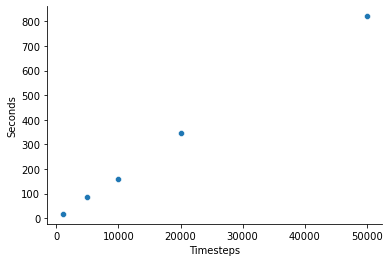

In [35]:
train_details_df = pd.concat([pd.Series(x) for x in train_details],axis=1).transpose().rename(columns={0:'Timesteps',
                                                                                                        1:'Buffer Size',
                                                                                                        2:"Seconds"}).sort_values(by='Timesteps')
sns.scatterplot(data=train_details_df,x='Timesteps',y='Seconds')
sns.despine()
train_details_df.head()

In [148]:

random.choice(env.lin_y[env.lin_y<env.y_max]) 

1150

### Predict

In [80]:
model = DQN.load(os.path.join(os.getcwd(),'models','dqn_template_matching_1092_1990_5000_5000'))

env = tmenv("/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method/data/tif_files/LKg_1092_1990.tif",
                        (1900,1650,50,100), # for testing_image red(5,5,20,45),
                        obs_shape_mult=(5,5),
                        compare_method='SSD',
                        sim_threshold=150,
                        print_st=False)

show = False
# rewards = []
log = {"Points":{},
       "Reward":{},
       "Results":{},
       "Closed":{}}

for episode in np.arange(0,50):
    if show==True:
        print(f"EPISODE {episode}")
    if show==True:
        fig,ax = plt.subplots()
    obs = env.reset()
    print(env.episode_origin)
    while True:
        if show==True:
            print(f"Previous action was {env.previous_action}")
            print(f"Point is {env.previous_point}")
            ax.imshow(env.frame_array)
            # ax.set_title(f"Episode {episode}")
            # gpd.GeoSeries(Point((env.window_x,env.window_y))).plot(ax=ax)
            display.display(plt.gcf())
        
        # Predict an action
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action) 
        # img = plt.imshow(env.render(mode='rgb_array'))
        # img.set_data(env.render(mode='rgb_array'))
                
        if done == True:
            log['Points'][episode] = env.log_points
            log['Reward'][episode] = env.ep_return
            log['Results'][episode] = env.log_res
            log['Closed'][episode] = env.log_closed
            # display.clear_output(wait=True)
            if show==True:
                print("Clearing")
            if show==True:
                time.sleep(0.25)
            break
    fig = None
env.close()
# print(f"Maximum reward achieved {max(rewards)}")


(8150, 2800)
(300, 7000)
(3100, 5700)
(1750, 2600)
(8650, 2200)
(7550, 10800)
(400, 700)
(1150, 5500)
(2950, 12900)
(7700, 600)
(7150, 5000)
(9150, 10700)
(2800, 11400)
(7500, 7100)
(50, 4000)
(8900, 10800)
(4350, 7100)
(1950, 5500)
(4300, 2600)
(1150, 9700)
(1200, 9100)
(4400, 6700)
(550, 11700)
(6850, 3100)
(4800, 2000)
(7050, 7500)
(8000, 9200)
(7350, 4900)
(9000, 1700)
(550, 5800)
(3700, 2000)
(2950, 2500)
(4850, 7100)
(5800, 9300)
(2050, 9400)
(4500, 5300)
(8550, 6800)
(8950, 1800)
(7750, 4300)
(6800, 6200)
(2050, 11800)
(4850, 6900)
(8150, 5600)
(8750, 8300)
(700, 5800)
(400, 8000)
(5100, 6800)
(800, 5400)
(7250, 8000)
(2700, 12700)


In [77]:
def getRandomID():
    letters = utils.calc_increment_space(1000,100)
    return random.choice(letters)

getRandomID()

500

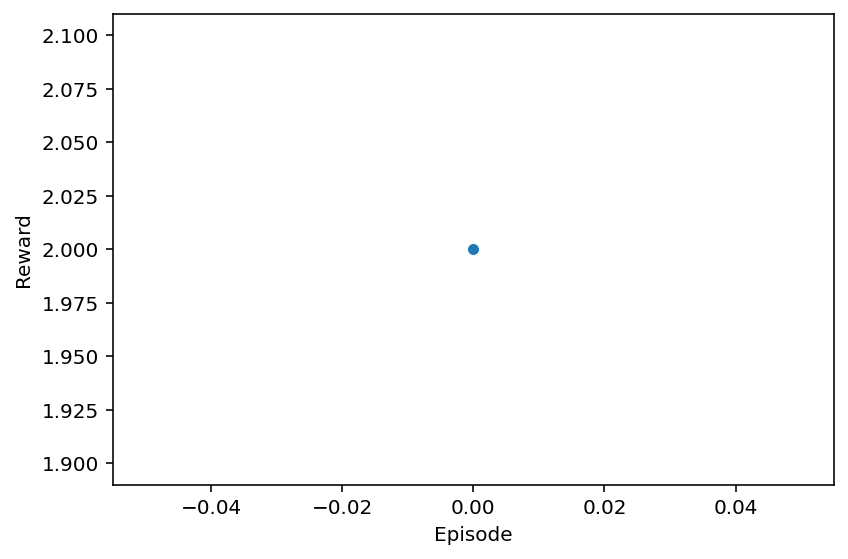

In [78]:
df_reward = pd.DataFrame([log['Reward']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Reward"}).set_index('Episode')
df_closed = pd.DataFrame([log['Closed']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Closed"}).set_index('Episode')
df_results = pd.DataFrame([log['Results']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Results"}).set_index('Episode')
df_points = pd.DataFrame([log['Points']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Points"}).set_index('Episode')

df = pd.concat([df_reward,df_closed,df_results,df_points],axis=1)

sns.scatterplot(data=df, x="Episode", y="Reward")
plt.tight_layout()

In [64]:
df.sort_values(by='Reward',ascending=False)


,Reward,Closed,Results,Points
Episode,,,,
54,135,False,"[141.0, 103.33333333333333, 139.0, 86.33333333...","[(7450, 10900), (7450, 10800), (7500, 10700), ..."
98,90,False,"[114.0, 91.33333333333333, 95.33333333333333, ...","[(800, 8600), (850, 8500), (900, 8400), (950, ..."
215,90,False,"[71.66666666666667, 93.0, 126.0, 56.6666666666...","[(350, 2900), (400, 2800), (450, 2700), (450, ..."
12,77,False,"[78.33333333333333, 115.33333333333333, 69.666...","[(2800, 11400), (2850, 11300), (2900, 11200), ..."
218,65,False,"[126.0, 56.666666666666664, 125.66666666666667...","[(450, 2700), (450, 2600), (450, 2500), (500, ..."
...,...,...,...,...
153,0,False,[165.66666666666666],"[(3050, 6700), (3100, 6600)]"
154,0,False,[156.0],"[(5050, 3300), (5100, 3200)]"
156,0,False,[154.0],"[(5850, 8000), (5850, 7900)]"


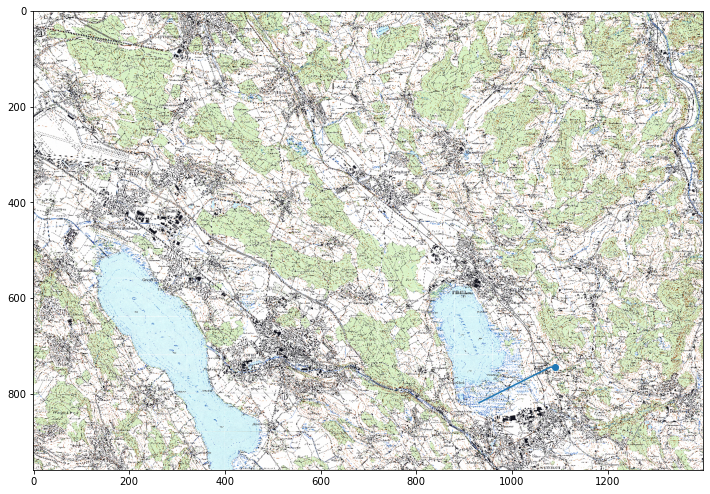

In [66]:
# look at path
factor = 0.1
fig,ax = plt.subplots(figsize=(12,12))
test_arr = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),path_1092_1990)), cv2.COLOR_BGR2RGB)
test_arr_sm = resize_image(test_arr,reduce_factor=factor)
ax.imshow(test_arr_sm)
high_reward_list = df.sort_values(by='Reward',ascending=False).iloc[0:1].index.tolist()
for epi in high_reward_list:
    plot_line_string(log['Points'][epi],reduce_factor=factor)

### Array Mask

In [ ]:

# dist_over = int(env.updated_point[1]-env.window_y / env.T_HEIGHT)

def embed(big_arr, small_arr, y_offset, x_offset):
    big_arr[y_offset:y_offset+small_arr.shape[0],
            x_offset:x_offset+small_arr.shape[1]] = small_arr
    return big_arr

def nan_array(height,width,mult_height,mult_width):
    arr = np.empty((height*mult_height,
                    width*mult_width,
                    3))
    arr[:] = np.nan
    return arr

def partial_array(next_origin_y,height,next_origin_x,width,mult_height,mult_width,image_array):
    if next_origin_y < 0:
        inc_over_y = int(next_origin_y / height)
    else:
        inc_over_y = 0
    if next_origin_x < 0 :
        inc_over_x = int(next_origin_x / width)
    else:
        inc_over_x = 0
    reset_origin_y = next_origin_y - (inc_over_y * height)
    reset_origin_x = next_origin_x + (inc_over_x * width)
    par_arr = crop_image(image_array,
                        reset_origin_y,
                        reset_origin_x,
                        height*(mult_height + inc_over_y),
                        width*(mult_width + inc_over_x))
    
    nan_arr = nan_array(height,width,mult_height,mult_width)
    print()
    
    embeded_arr = embed(nan_arr,
                        par_arr,
                        nan_arr.shape[0] - height*(mult_height + inc_over_y),
                        nan_arr.shape[1] - width*(mult_width + inc_over_x))
    return embeded_arr,par_arr


next_origin_y = env.updated_point[1]-env.window_y
next_termination_y = next_origin_y + env.obs_shape_mult_height * env.T_HEIGHT
next_origin_x = env.updated_point[0]-env.window_x
next_termination_x = next_origin_x + env.obs_shape_mult_width * env.T_WIDTH

e_arr,par_arr = partial_array(next_origin_y,
                        env.T_HEIGHT,
                        next_origin_x,
                        env.T_WIDTH,
                        env.obs_shape_mult_height,
                        env.obs_shape_mult_width,
                        env.image_array)

# (next_origin_y - env.T_HEIGHT)
e_arr
fig,ax = plt.subplots(1,2)
ax[0].imshow(e_arr)
# ax[1].imshow(par_arr)


### Old Build

In [220]:
class TemplateMatchingEnv2(gym.Env):
    def __init__(self, image, template, obs_shape_mult=(3,3),sim_threshold=1000):
        super(TemplateMatchingEnv, self).__init__()
        self.image = image
        # self.reward_range = (0, 100000000)
        self.sim_threshold = sim_threshold
        
        # load template details
        self.template_array = template
        self.T_HEIGHT, self.T_WIDTH, self.T_DEPTH = self.template_array.shape
        # print(f"T_Height is {self.T_HEIGHT}")
        # print(f"T_Width is {self.T_WIDTH}")
        # set observation shape 
        self.obs_space_height = self.T_HEIGHT*obs_shape_mult[0]
        self.obs_space_width = self.T_WIDTH*obs_shape_mult[1]
        # print(f"Obs_num_cols is {self.obs_space_width}")
        # print(f"Obs_num_rows is {self.obs_space_height}")
        
        self.obs_shape_mult_height = obs_shape_mult[0]
        self.obs_shape_mult_width = obs_shape_mult[1]
        
        # Define a 2-D observation space
        self.observation_shape = (self.obs_space_height,
                                  self.obs_space_width,
                                  3)

        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Action to choose the next agent location 
        # 0 -> 8 corresponds to the list of neighbor frames 
        self.action_space = spaces.Discrete(8)
        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum moves the frame can make before resetting
        self.max_moves = 8
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the frame on canvas
        # for elem in self.elements:
        # elem_shape = self.frame.icon.shape
        # x,y = self.frame.x, self.frame.y
        self.canvas = self.image_array
        # self.canvas[y:y + elem_shape[0], x:x + elem_shape[1]] = self.frame.icon

        text = f"Turns Remaining: {self.moves_left} | Rewards: {self.ep_return}"

        # Put the info on canvas 
        # self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
        #         0.8, (0,0,0), 1, cv2.LINE_AA)

    def reset(self):
        print('Reset')
        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1
        self.image_array = None
        self.previous_action = None
        self.moves_taken = 0
        self.points = []
        self.moves = []
        self.actions = np.arange(0,self.action_space.n)
        
        # Reset the moves allowed
        self.moves_left = self.max_moves

        # Reset the reward
        self.ep_return  = 0

        # Intialise the frame
        
        # origin point for frame
        self.frame_y_origin = int(np.floor(self.obs_shape_mult_height/2)) * self.T_HEIGHT
        self.frame_x_origin = int(np.floor(self.obs_shape_mult_width/2)) * self.T_WIDTH
        # print(self.frame_y_origin,self.frame_x_origin)
        
        # crop image to observation space
        self.image_height, self.image_width, self.image_depth = self.image.shape
        self.height_buffer = self.T_HEIGHT*(self.obs_shape_mult_height+1)
        self.width_buffer = self.T_WIDTH*(self.obs_shape_mult_width+1)
        self.y_max = self.image_height-(self.height_buffer)
        self.x_max = self.image_width-(self.width_buffer)
        
        self.lin_y = np.linspace(0,self.image_height,int(np.floor(
            self.image_height/self.T_HEIGHT)),dtype="int16")
        self.lin_x = np.linspace(0,self.image_width,int(np.floor(
            self.image_width/self.T_WIDTH)),dtype="int16")
        
        
        self.random_y_origin = random.choice(self.lin_y[self.lin_y<+self.y_max]) # random.randint(0, self.y_max)
        self.random_x_origin = random.choice(self.lin_x[self.lin_x<+self.x_max]) # random.randint(0, self.x_max)
        self.episode_origin = (self.random_y_origin,self.random_x_origin)
        # self.previous_point = self.episode_origin
        self.points.append(self.episode_origin)
        # print(self.random_y_origin,self.random_x_origin)
        
        self.image_array = crop_image(self.image,
                                      self.random_y_origin,
                                      self.random_x_origin,
                                      self.obs_space_height,
                                      self.obs_space_width)
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_array.shape



        # Initialise the analysis frame
        self.frame = Frame('frame',
                           self.y_max,
                           self.x_max,
                           self.frame_y_origin,
                           self.frame_x_origin,
                           self.T_HEIGHT,
                           self.T_WIDTH)
        self.frame.set_position(self.frame_y_origin,self.frame_x_origin)

        # Intialise the elements 
        self.elements = [self.image_array,self.frame]

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # return the observation
        return self.canvas 
        
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            plt.imshow(self.canvas)
        
        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    
    
    def test_ssd_match(self):
    
        self.frame_array = crop_image(self.image_array,
                                 self.frame_y_origin,
                                 self.frame_x_origin,
                                 self.T_HEIGHT,
                                 self.T_WIDTH)
        
        self.ssd_ = Sum_of_squared_differences(self.frame_array,self.template_array)
        # result_.append(ssd_) # log results
        res = self.ssd_
        print(f"SSD result is {res}")
        if res>self.sim_threshold:
            return True

        return False
        
    def generate_possible_pts(self):
        all_moves = [(self.T_HEIGHT,0),
                          (self.T_HEIGHT,self.T_WIDTH*-1),
                          (0,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,0),
                          (self.T_HEIGHT*-1,self.T_WIDTH),
                          (0,self.T_WIDTH),
                          (self.T_HEIGHT,self.T_WIDTH)]
        self.poss_pts = [tuple_addition(self.previous_point,pt) for pt in all_moves]
        return self.poss_pts
    
    def update_after_move(self):
        
        # store some data
        self.previous_action = self.action
        self.updated_point = tuple_addition(self.previous_point,self.movement)
        self.points.append(self.updated_point)
        self.moves.append(self.get_action_meanings()[self.action])
        # move the image array   
        self.image_array = crop_image(self.image,
                                      self.random_y_origin + self.movement[0],#self.frame_y
                                      self.random_x_origin + self.movement[1],#self.frame_x
                                      self.obs_space_height,
                                      self.obs_space_width)
    
    def step(self):
        self.possible_actions = self.actions
        # Flag that marks the termination of an episode
        done = False
        # Assert that it is a valid action 
        # assert self.action_space.contains(action), "Invalid Action"

        if self.moves_taken < 1:
            self.previous_point = self.episode_origin
        else:
            self.previous_point = self.updated_point

        # Decrease the moves left 
        self.moves_left -= 1 
        self.moves_taken += 1 
        print(f"Moves left, {self.moves_left}")
        
        for n,pt in enumerate(self.generate_possible_pts()):
            if pt==self.episode_origin:
                pass
            elif pt in self.points:
                np.delete(env.possible_actions,[n])
                
        if len(self.possible_actions)==0:
            print('No actions possible')
            done = True
            
        self.action = random.choice(self.possible_actions)
        
        # apply the action to the frame
        print(f"Action is {self.action}, {self.get_action_meanings()[self.action]}")
        if self.action == 0: # south
            self.movement = (self.T_HEIGHT,0)
        elif self.action == 1: # southwest
            self.movement = (self.T_HEIGHT,self.T_WIDTH*-1)
        elif self.action == 2: # west
            self.movement = (0,self.T_WIDTH*-1)
            #self.frame.move(0,T_WIDTH*-1)
        elif self.action == 3: # northwest
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH*-1)
        elif self.action == 4: # north
            self.movement = (self.T_HEIGHT*-1,0)
        elif self.action == 5: # northeast
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH)
        elif self.action == 6: # east
            self.movement = (0,self.T_WIDTH)
        elif self.action == 7: # southeast
            self.movement = (self.T_HEIGHT,self.T_WIDTH)
        
        self.update_after_move()
        match_ = self.test_ssd_match() # crop is done in function
        if match_ is True:
            print("Match")
            # Reward for a match.
            reward_a = 1
            # Reward for contiguous matches.
            reward_b = 1 * self.moves_taken
            reward = reward_a+reward_b
            
            if self.points[0] == self.points[-1]:
                print('Episode origin point visited. Loop created. Next Episode')
                reward += self.moves_taken**2
                
                # Increment the episodic return
                self.ep_return += reward

                # Draw elements on the canvas
                self.draw_elements_on_canvas()
                self.moves_left = 0
                done = True
            else:
                # Reset the moves allowed
                self.moves_left = self.max_moves
        else:
            print('No match, next epsiode')
            reward = 0
            done = True
        
        
        
        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of moves, end the episode.
        if self.moves_left == 0:
            done = True

        return self.canvas, reward, done, []
    
        

In [ ]:

class TemplateMatchingEnv_1(gym.Env):
  """A template matching environment for OpenAI gym"""
  metadata = {'render.modes': ['human']}
  def __init__(self, image_array, template_array):
    super(TemplateMatchingEnv, self).__init__()
    self.image_array = image_array
    self.template_array = template_array
    self.I_HEIGHT, self.I_WIDTH = image_array.shape
    self.T_HEIGHT, self.T_WIDTH = template_array.shape
    self.reward_range = (0, int(np.ceil((self.I_HEIGHT/self.T_HEIGHT)*2 + (self.I_WIDTH/self.T_WIDTH)*2)))
    
    # Action to choose the next agent location 
    # 0 -> 8 corresponds to the lsit of neighbor frames 
    self.action_space = spaces.Discrete(8, start=0)
    
    # Setting the observation space to be a frame of the whole image 
    # observation is also set to look at RGB
    self.observation_shape = (self.T_HEIGHT*10,self.T_WIDTH*10 , 1)
    self.observation_space = spaces.Box(low=0, high=255, shape=self.observation_shape, dtype=np.uint8)
  
  def reset(self):
    # Reset the state of the environment to an initial state
    # Set the current step to a random point within the data frame
    self.current_step = (random.randint(0, self.I_HEIGHT-self.T_HEIGHT),
                         random.randint(0, self.I_WIDTH-self.T_WIDTH)) # (y,x)
    return self._next_observation()
  
  def _next_observation(self):
    # Get the surrounding boxes
    # need to control for the edge conditions:
    rois = find_regions_interest(self.image_array,
                                 self.current_step[1],
                                 self.current_step[0],
                                 self.T_WIDTH,
                                 self.T_HEIGHT)
    return rois
  
  def step(self, action):
    # Execute one time step within the environment
    self._take_action(action)
    self.current_step += 1
    if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
      self.current_step = 0
    delay_modifier = (self.current_step / MAX_STEPS)
    
    reward = self.balance * delay_modifier
    done = self.net_worth <= 0
    obs = self._next_observation()
    print(obs)
    return obs, reward, done, {}

  def _take_action(self, action):
    # Set the current price to a random price within the time step
    current_price = random.uniform(
      self.df.loc[self.current_step, "Open"],
      self.df.loc[self.current_step, "Close"])
    action_type = action[0]
    amount = action[1]
    # if action_type < 1:
    #   # Buy amount % of balance in shares
    #   total_possible = self.balance / current_price
    #   shares_bought = total_possible * amount
    #   prev_cost = self.cost_basis * self.shares_held
    #   additional_cost = shares_bought * current_price
    #   self.balance -= additional_cost
    #   self.cost_basis = (prev_cost + additional_cost) / 
    #                           (self.shares_held + shares_bought)
    #   self.shares_held += shares_bought
    # elif actionType < 2:
    #   # Sell amount % of shares held
    #   shares_sold = self.shares_held * amount . 
    #   self.balance += shares_sold * current_price
    #   self.shares_held -= shares_sold
    #   self.total_shares_sold += shares_sold
    #   self.total_sales_value += shares_sold * current_price
    # self.netWorth = self.balance + self.shares_held * current_price
    # if self.net_worth > self.max_net_worth:
    #   self.max_net_worth = net_worth
    # if self.shares_held == 0:
    #   self.cost_basis = 0

In [ ]:
def train(env, agent, replay_buffer, T=20000, n_theta=100):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of
    '''
    

    # for plotting
    returns = []
    episode_rewards = 0

    s_t = env.reset()
    for t in range(T):
        # synchronize Q and Q_
        if t%n_theta == 0:
            agent.synchronize()

        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)

        # store data into replay buffer
        replay_buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next

        # learn by sampling from replay buffer
        for batch in replay_buffer.sample():
            agent.update(*batch)

        # for plotting
        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                returns.append(episode_rewards[i])
                episode_rewards[i] = 0

        # epsilon decay
        agent.decay_epsilon(t/T)

    plot_returns(returns)
    return agent

def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

In [ ]:
%%time

# global variables
SIMILARTY_THRESHOLD = 3362500
MAX_STEPS = 100
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = VectorizedEnvWrapper(TemplateMatchingEnv(image, template), num_envs=4)
agent = DeepQLearner(env, alpha=1e-3, gamma=0.95)
replay_buffer = ReplayBuffer(batch_size=1)
agent = train(env, agent, replay_buffer, T=20000)

### Trash

In [ ]:

## SCript to run the RL

# global variables
SIMILARTY_THRESHOLD = 0
MAX_STEPS = 2000
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = TemplateMatchingEnv(image, template)
model = DQN("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=MAX_STEPS)

model.save("/models/cnn_templatematch")  
model = DQN.load("/models/cnn_templatematch") 


# iterate the RL 
obs = env.reset()
for episode in np.arange(0,TOTAL_EPISODES): 
  action, _states = model.predict(obs, deterministic=True) # do something to illict an action 
  obs, rewards, done, info = env.step(action) # take a step based on the new action
  env.render()

NameError: name 'pd' is not defined